In [ ]:
# Import relevant libraries
include("./math405.jl")

In [137]:
function _iterate(f, u0, h, Tf, stepper; kwargs...)
    t = 0:h:Tf
    U = zeros(length(u0), length(t))
    U[:, 1] = u0
    for n = 2:length(t)
        U[:, n] = stepper(U[:,n-1], f, h; kwargs...)
    end 
    return U, t
end  

u2rv(u) = (n = length(u)÷4; (reshape(u[1:2*n], (2, n)), reshape(u[2*n+1:end], (2, n))))
rv2u(r, v) = [r v][:]

# TODO compare with RK



# For Simple Harmonic Oscillators
function explicit_euler_step(u, f, h)   
    n = length(u) ÷ 2
    r, v = u[1:n], u[n+1:end]
    r1 = r + h * v 
    v1 = v + h * f(r)
    return rv2u(r1, v1)
end

function eulerA_step(u, f, h)   
    n = length(u) ÷ 2
    r, v = u[1:n], u[n+1:end]
    r = r + h * v 
    v = v + h * f(r)
    return rv2u(r, v)
end

function verlet_step(u, f, h)
    n = length(u) ÷ 2
    r, v = u[1:n], u[n+1:end]
    v = v + f(r) * h * 0.5
    r = r + v * h
    v = v + f(r) * h * 0.5
    return rv2u(r, v)
end

function verlet_step(u, f, h)
    n = length(u) ÷ 2
    r, v = u[1:n], u[n+1:end]
    v = v + f(r) * h * 0.5
    r = r + v * h
    v = v + f(r) * h * 0.5
    return rv2u(r, v)
end

explicit_euler_method(f, u0, h, Tf) = _iterate(f, u0, h, Tf, explicit_euler_step)
eulerA_method(f, u0, h, Tf) = _iterate(f, u0, h, Tf, eulerA_step)
verlet_method(f, u0, h, Tf) = _iterate(f, u0, h, Tf, verlet_step)


verlet_method (generic function with 1 method)

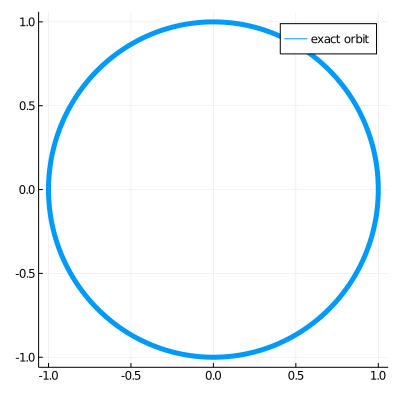

In [167]:
harmosc(u, c=1.0) = [u[2], - c * u[1]]
u0 = [1.0, 0.0]
h = 0.1
Tf = 6 * π

plt1 = plot(cos, sin, 0, 2*π, lw=5, label = "exact orbit", size = (400,400))

## Introduction to Symplectic Integrators

### Formal Introduction

Symplectic methods belong to a larger class of *geometric numerical integrators*. These algorithms preserve geometric properties inherent in the system. As a quick primer, in the case of symplectic integrators, these methods preserve the sympletic structure inherent in the phase space representation of the dynamics of the problem.

Now the precise definition of "symplectic" is rather involved. We'll 

So if a problem has a symplectic property - i.e. it's a symplectic problem - it is well suited to be solved using symplectic integrators. (Problems are symplectic if the solutions to the problem lie on a symplectic manifold.) 

It turns out that Hamiltonian Systems are "symplectic," making them a good candidate to be be solved using symplectic integrators.

[show how the solution to a hamiltonian system is sympletic & what properties of the system leads it to being sympletic]

Symplectic integrators are algorithms that explicit the aforementioned geometric property of symplectic problems


**Identifying Symplectic Integrators**

By the same token there are a variety of ways of assessing if an integrator is symplectic. A formal way of doing so is by evaluating the following expression and verifying if the result is equivalent to $J$ (symplectic matrix).
$$
f'(z)^TJf(z) = J
$$
We'll use this shortly on a series of Euler Methods. Hopefully that will make the process more clear.


Alternatively, we can delve into the consequences of integrators being symplectic. We'll look at two properties in symplectic systems in particular:
* Preservation of Phase-Space Volume
* Time-reversibility

Let's talk about the preservation of phase space volume first. Recall that when solving a Hamiltonian system what we are trying to obtain



**Quick Aside:** The order of numerical integrators. For methods of order n,  $u_{t+1} - U(t_0+\Delta t) = O(t^{n+1})$ as $\Delta t \rightarrow 0$ 

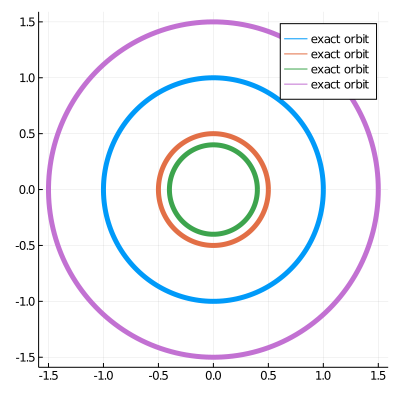

In [262]:
harmosc(u, c=1.0) = [u[2], - c * u[1]]
u0 = [1.0, 0.0]
h = 0.1
Tf = 6 * π

# ps_plt = plot(cos, sin, 0, 2*π, lw=5, label = "exact orbit", size = (400,400))
func_cos1(x)= cos(x)/2
func_sin1(x) = sin(x)/2
func_cos2(x)= cos(x)/2.5
func_sin2(x) = sin(x)/2.5
func_cos3(x)= cos(x)*1.5
func_sin3(x) = sin(x)*1.5
ps_plt = plot(cos, sin, 0, 2*π, lw=5, label = "exact orbit", size = (400,400))
plot!(ps_plt, func_cos1, func_sin1, 0, 2*π, lw=5, label = "exact orbit", size = (400,400))
plot!(ps_plt, func_cos2, func_sin2, 0, 2*π, lw=5, label = "exact orbit", size = (400,400))
plot!(ps_plt, func_cos3, func_sin3, 0, 2*π, lw=5, label = "exact orbit", size = (400,400))

### Explicit/Implicit Euler Method

Let's start with what we've already explored in class. We'll revisit the harmonic oscillator whose Hamiltonian is defined as follows: $H = \frac{1}{2}q^2+\frac{1}{2}p^2$. The constant terms will be neglected for the time being for simplicity. 

Both explicit (forward) or implicit (backward) euler methods can be used to solve the Hamiltonian system for trajectories of $p$ and $q$. However, as we are already aware both of these methods do not conserve total energy. As shown in the equations below, the numerical solution diverges from the true solution - **quadratically** in the case of the harmonic oscillator shown below.

$$
    H_{n+1}
    =
    \begin{cases}
        (1+h^2) H_n, & \text{Explicit Euler method}  \\
        \frac{1}{1+h^2} H_n, & \text{Implicit Euler method} 
    \end{cases}
$$

*Quick Derivation:*
$$
\text{Explicit Euler Method}
    =
\begin{cases}
q_{t+1} = q_t + p_t h \\
p_{t+1} = p_t - q_t h
\end{cases}
$$

$$\begin{aligned}
H_{t+1} - H_t &= \frac{1}{2}\left( q_{t+1}^2-q_t +p_{t+1}^2-p_t \right) \\
&= \frac{1}{2}\left( (q_t + p_t h)^2-q_t + (p_t -q_t h)^2-p_t \right) \\
&= \frac{1}{2}\left( p_t^2h^2 + q_t^2h^2 \right) \\
&= \frac{1}{2}(p_t^2 + q_t^2)h^2 \\
&= H_t h^2 \\
H_{t+1} &= (1+h^2) H_t
\end{aligned}$$

Similarly we can obtain the expression for Implicit Euler Method.

It's worth noting that in the case of the explicit euler method the system creates energy while the implicit euler method dissipate energy. Also, having explored the formal definition of symplectic integrators above, we can verify that both of these Euler methods are indeed not symplectic.


Explicit Euler Method can be expressed in matrix form.
$$
\begin{bmatrix}
q_{t+1} \\
p_{t+1} 
\end{bmatrix}
=
\begin{bmatrix}
1 & \Delta t \\
-\Delta t & 1
\end{bmatrix}
\begin{bmatrix}
q_{t} \\
p_{t} 
\end{bmatrix}
$$

$$
f'(z)^TJf'(z) =
\begin{bmatrix}
1 & \Delta t \\
-\Delta t & 1
\end{bmatrix}^T
\begin{bmatrix}
0 & 1 \\
-1 & 0
\end{bmatrix}
\begin{bmatrix}
1 & \Delta t \\
-\Delta t & 1
\end{bmatrix}
=
\begin{bmatrix}
0 & 1+\Delta t^2 \\
-(1+\Delta t^2) & 0
\end{bmatrix}
\text{ (Not symplectic)}
$$

plt2 = Plot{Plots.GRBackend() n=2}


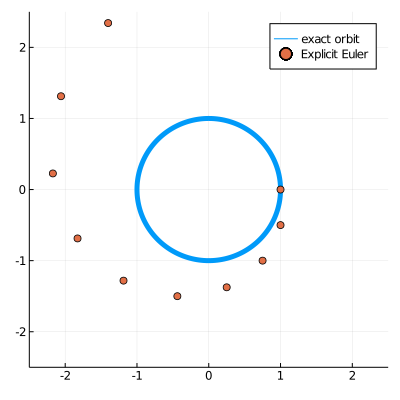

In [165]:
Uee, tee = explicit_euler_method(r -> -r, [1.0,0.0], 0.5, 6π) 
plt2 = plot(cos, sin, 0, 2*π, lw=5, label = "exact orbit", size = (400,400))
scatter!(plt2, Uee[1,:], Uee[2,:], label = "Explicit Euler", xlims=(-2.5, 2.5), ylims = (-2.5, 2.5));
@show plt2

plt3 = Plot{Plots.GRBackend() n=22}


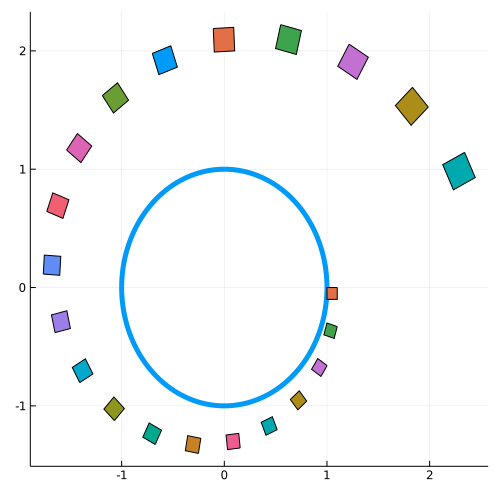

In [164]:
# Let's look at the phase area
step_size = 0.3
Uee_1, tee_1 = explicit_euler_method(r -> -(r), [1.1, 0.0], step_size, 2*π)
Uee_2, tee_2 = explicit_euler_method(r -> -(r), [1.1, -0.1], step_size, 2*π)
Uee_3, tee_3 = explicit_euler_method(r -> -(r), [1.0, -0.1],step_size, 2*π)
Uee_4, tee_4 = explicit_euler_method(r -> -(r), [1.0, 0.0], step_size, 2*π)

plt3 = plot(sin, cos, 0, 2*π, lw=5, label=false, size = (500,500))

for i in 1:size(tee_4)[1]
    plot!(Shape([(Uee_1[1,i], Uee_1[2,i]), (Uee_2[1,i], Uee_2[2,i]), (Uee_3[1,i], Uee_3[2,i]), (Uee_4[1,i], Uee_4[2,i])]), labels=false);
end

@show plt3

### Symplectic Euler Method

Combining explicit and implicit methods can yield symplectic integrators. In order to produce symplectic euler method, we can write $q$ in explicit form  and $p$ in implicit form or vice versa. Each approach leads to Euler-A and Euler-B methods respectively.

Euler-A
$$

$$

**Shawdow Hamiltonian**

Try to mathematically bound the periodic perturbations.

So, as we've explored in Assignment 3, if the shawdow hamiltonian is preserved, we can place a bound on the periodic perturbations of the exact hamiltonian ($H$). This is an important property of symplectic integrators that make them well-suited for long-term integration.

But some may have ask:
   * Where does the expression for the shawdow hamiltonian come from? Does it differ for each method used?
   * How is this related to the symplectic property of these integrators?
   
Unfortunately, the answer to these questions are slightly more involved. However, we'll leave some pointers here for those that want to explore further.

The essence of it is that it comes from the "Baker–Campbell–Hausdorff formula" which yields an exact expression for the 

plt1 = Plot{Plots.GRBackend() n=4}


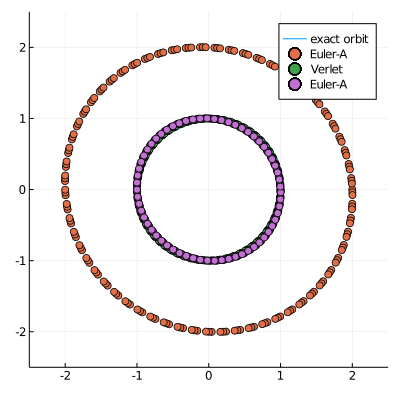

In [266]:
Ua, ta = eulerA_method(r -> -r, [1.0,0.0], 0.1, 6π) 
scatter!(plt1, Ua[1,:], Ua[2,:], label = "Euler-A", xlims=(-2.5, 2.5), ylims = (-2.5, 2.5));

@show plt1

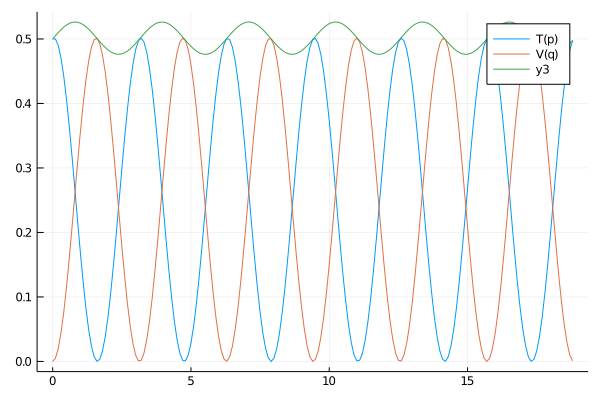

In [188]:
Ha = [ 0.5*norm(u)^2 for u in eachcol(Ua)]
r = [0.5*U^2 for U in Ua[1,:]]
v = [0.5*U^2 for U in Ua[2,:]]
plot(ta, r, label="T(p)")
plot!(ta, v, label="V(q)")
plot!(ta, Ha)

plt4 = Plot{Plots.GRBackend() n=22}


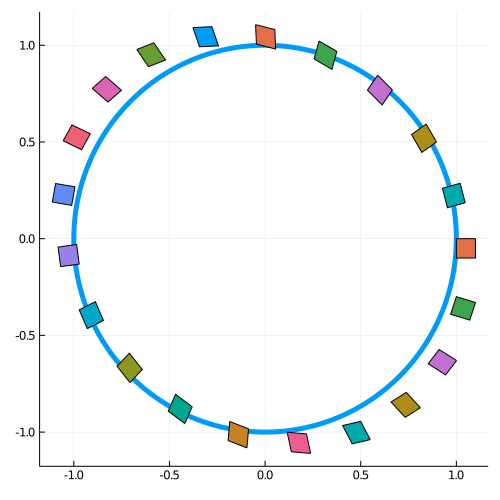

In [191]:
Ua_1, ta_1 = eulerA_method(r -> -(r), [1.1, 0.0], 0.3, 2*π)
Ua_2, ta_2 = eulerA_method(r -> -(r), [1.1, -0.1], 0.3, 2*π)
Ua_3, ta_3 = eulerA_method(r -> -(r), [1.0, -0.1], 0.3, 2*π)
Ua_4, ta_4 = eulerA_method(r -> -(r), [1.0, 0.0], 0.3, 2*π)

plt4 = plot(sin, cos, 0, 2*π, lw=5, label=false, size = (500,500))

for i in 1:size(tv_4)[1]
    plot!(Shape([(Ua_1[1,i], Ua_1[2,i]), (Ua_2[1,i], Ua_2[2,i]), (Ua_3[1,i], Ua_3[2,i]), (Ua_4[1,i], Ua_4[2,i])]), labels=false);
end

@show plt4

### Quick Summary before we introduce other Symplectic Integrators

* Given a symplectic problem (notably Hamiltonian systems) you would use symplectic integrators in situations where **long-term integration** is required. Note that energy isn't exactly conserved due to periodicity.
    * If very high accuracy is needed "normal" integrators such as adaptive RK methods are worth considering.
* The alternative is to use a very accurate method (adaptive methods fare reasonably well). The energy would drift due to the lack of periodicity, but the margin will be small due to high accuracy.
* In terms of computational efficiency, it's worth exploring/benchmarking both options for the particular usecase.

## Verlet ( Leapfrog) Method
### Intuition behind the Verlet/Leapfrog Method

At each step of the Euler method we would approximate,

$$q_{n+1} = q_{n} + h p_{n} \quad (1)$$ 
$$p_{n+1} = p_n + h F(q_n) \quad (2)$$

A better approximation for $q_{n+1}$ and $p_{n+1}$ would be,

$$q_{n+1} = q_{n} + h p_{n + \frac{1}{2}}$$
$$p_{n+1} = p_{n} + h F(q_{n + \frac{1}{2}})$$

However we do not know $p_{n + \frac{1}{2}}$ or $q_{n + \frac{1}{2}}$. For know let us assume we do know $p_{n + \frac{1}{2}}$, then we can have the following basic integration formula,

$$q_{n+1} = q_{n} + h p_{n + \frac{1}{2}} \quad (3)$$
$$p_{n+\frac{3}{2}} = p_{n + \frac{1}{2}} + h F(q_{n + 1}) \quad (4)$$

This highlights why this method is known as leapfrog,


We would need $v_{\frac{1}{2}}$ as an initial condition to use the above integration formulas. We can approximate $p_{\frac{1}{2}}$ using a half Euler step at the very begining,

$$p_{\frac{1}{2}} = p_0 + \frac{1}{2}h F(q_0)$$

To get $p$ at the same time as $q$, we can consider $(4)$ to be made up of two equal half steps, were a single step would be,

$$p_{n+\frac{1}{2}} = p_{n} + \frac{1}{2}h F(q_n)$$
$$q_{n+1} = q_{n} + h p_{n+\frac{1}{2}}$$
$$p_{n+1} = p_{n+\frac{1}{2}} + \frac{1}{2} h F(q_{n+1})$$

Hence we get the following step function,


We would need $p_{\frac{1}{2}}$ as an initial condition to use the above integration formulas. We can approximate $p_{\frac{1}{2}}$ using a half Euler step at the very begining,

$$p_{\frac{1}{2}} = p_0 + \frac{1}{2}h F(q_0)$$

To get $p$ at the same time as $q$, we can consider $(4)$ to be made up of two equal half steps, were a single step would be,

$$p_{n+\frac{1}{2}} = p_{n} + \frac{1}{2}h F(q_n)$$
$$q_{n+1} = q_{n} + h p_{n+\frac{1}{2}}$$
$$p_{n+1} = p_{n+\frac{1}{2}} + \frac{1}{2} h F(q_{n+1})$$

Hence we get the following step function,


We would need $p_{\frac{1}{2}}$ as an initial condition to use the above integration formulas. We can approximate $p_{\frac{1}{2}}$ using a half Euler step at the very begining,

$$p_{\frac{1}{2}} = p_0 + \frac{1}{2}h F(q_0)$$

To get $p$ at the same time as $q$, we can consider $(4)$ to be made up of two equal half steps, were a single step would be,

$$p_{n+\frac{1}{2}} = p_{n} + \frac{1}{2}h F(q_n)$$
$$q_{n+1} = q_{n} + h p_{n+\frac{1}{2}}$$
$$p_{n+1} = p_{n+\frac{1}{2}} + \frac{1}{2} h F(q_{n+1})$$

Hence we get the following step function,


In [263]:
function verlet_step(u, f, h)
    n = length(u) ÷ 2
    q, p = u[1:n], u[n+1:end]
    p = p + f(q) * h * 0.5
    q = q + p * h
    p = p + f(q) * h * 0.5
    return rv2u(q, p)
end

verlet_method(f, u0, h, Tf) = _iterate(f, u0, h, Tf, verlet_step)

verlet_method (generic function with 1 method)

verlet_plt = Plot{Plots.GRBackend() n=2}


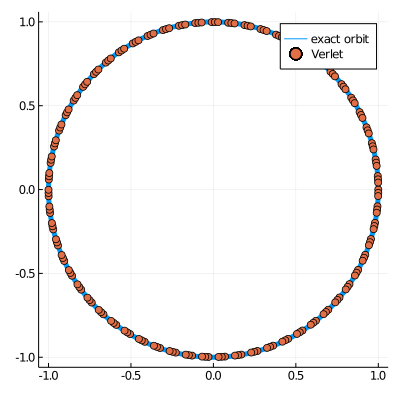

In [267]:
Uv, tv = verlet_method(q -> -q, [1.0,0.0], 0.1, 6*π)
verlet_plt = plot(cos, sin, 0, 2*π, lw=5, label = "exact orbit", size = (400,400))
scatter!(verlet_plt, Uv[1,:], Uv[2,:], label = "Verlet");

@show verlet_plt

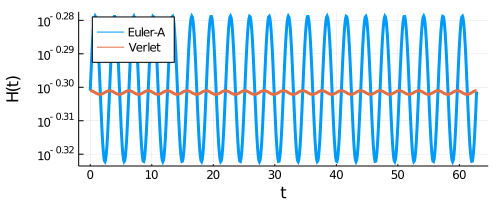

In [8]:
Ha, Hv = tuple([ [ 0.5*norm(u)^2 for u in eachcol(U) ] for U in (Ua, Uv) ]...)

plot(tv, Ha, yaxis = :log10, lw=3, label = "Euler-A", size = (500, 200), legend = :topleft)
plot!(tv, Hv, label = "Verlet", lw=3, xlabel = "t", ylabel = "H(t)")

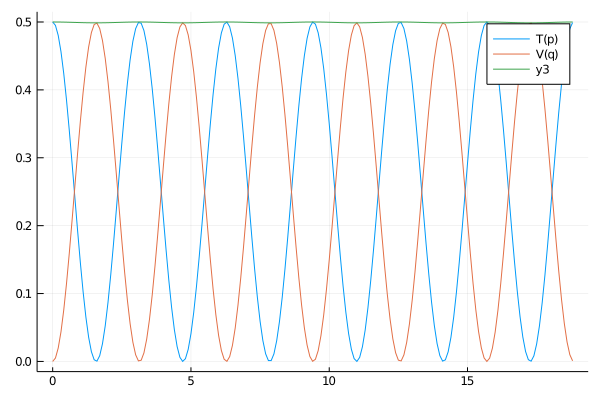

In [47]:
Hv = [ 0.5*norm(u)^2 for u in eachcol(Uv) ]
r = [0.5*U^2 for U in Uv[1,:]]
v = [0.5*U^2 for U in Uv[2,:]]
plot(tv, r, label="T(p)")
plot!(tv, v, label="V(q)")
plot!(tv, Hv)

plt2 = Plot{Plots.GRBackend() n=22}


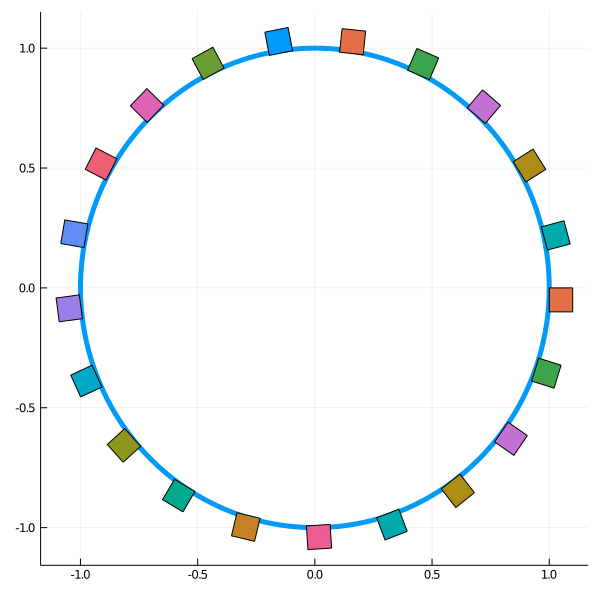

In [116]:
Uv_1, tv_1 = verlet_method(r -> -(r), [1.1, 0.0], 0.3, 2*π)
Uv_2, tv_2 = verlet_method(r -> -(r), [1.1, -0.1], 0.3, 2*π)
Uv_3, tv_3 = verlet_method(r -> -(r), [1.0, -0.1], 0.3, 2*π)
Uv_4, tv_4 = verlet_method(r -> -(r), [1.0, 0.0], 0.3, 2*π)

plt2 = plot(sin, cos, 0, 2*π, lw=5, label=false, size = (600,600))

for i in 1:size(tv_4)[1]
    plot!(Shape([(Uv_1[1,i], Uv_1[2,i]), (Uv_2[1,i], Uv_2[2,i]), (Uv_3[1,i], Uv_3[2,i]), (Uv_4[1,i], Uv_4[2,i])]), labels=false);
end

@show plt2

### Examples of solving Hamiltonian Systems with Verlet Method

In [235]:
function verlet_kepler_step(u, h, H)
    n = length(u) ÷ 2
    r, v = u[1:n], u[n+1:end]
    
    pdot(q,p) = ForwardDiff.gradient(q->-H(q, p), q)
    qdot(q,p) = ForwardDiff.gradient(p-> H(q, p), p)
    
    v = v + pdot(r,v) * h * 0.5
    r = r + v * h
    v = v + pdot(r,v) * h * 0.5
    return rv2u(r, v)
end

function verlet_kepler(u0, h, Tf, H)
    t = 0:h:Tf
    U = zeros(length(u0), length(t))
    U[:, 1] = u0
    for n = 2:length(t)
        U[:, n] = verlet_kepler_step(U[:,n-1], h, H)
    end 
    return U, t
end  

verlet_kepler (generic function with 1 method)

In [258]:
# Define the Hamiltonian
H(q,p) = norm(p)^2/2 - inv(norm(q))
AngM(q,p) = q[1]*p[2] - p[1]*q[2]

pdot(dp,p,q,params,t) = ForwardDiff.gradient!(dp, q->-H(q, p), q)
qdot(dq,p,q,params,t) = ForwardDiff.gradient!(dq, p-> H(q, p), p)

q0 = [0.4, 0.0]
p0 = [0.0, 2.0]

initial_cond = (q0, p0)
initial_first_integrals = (H(initial_cond...), AngM(initial_cond...))
tspan = (0,100.)
prob = DynamicalODEProblem(pdot, qdot, p0, q0, tspan)
sol = solve(prob, VerletLeapfrog(), dt=5//10);

plt_kepler = Plot{Plots.GRBackend() n=1}


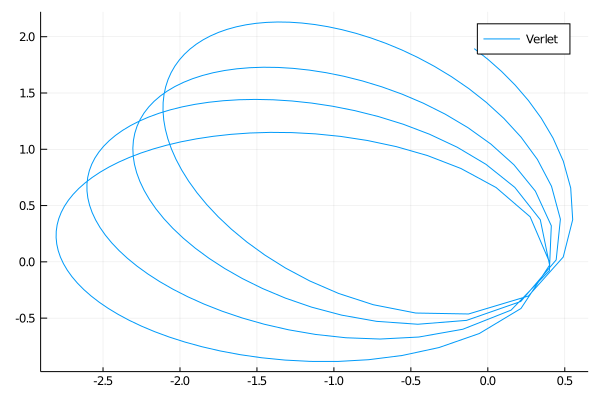

In [255]:
Uv,tv = verlet_kepler(vcat(q0,p0), 0.05, 100, H)
plt_kepler = plot(Uv[1,:], Uv[2,:], label = "Verlet");
@show plt_kepler


In [238]:
Uv

4×401 Array{Float64,2}:
 0.4   0.392188   0.369587   0.334376  …  -0.068596  -0.12836   -0.187344
 0.0   0.1        0.196229   0.285763      0.703158   0.732655   0.7577
 0.0  -0.304133  -0.57812   -0.802457     -1.20014   -1.18748   -1.16983
 2.0   1.96229    1.85763    1.70673       0.639777   0.545419   0.461072

In [253]:
plot_orbit(sol) = plot(sol,vars=(2,1), lab="Orbit", title="Kepler Problem Solution")

function plot_first_integrals(sol, H, L)
    plot(initial_first_integrals[1].-map(u->H(u[2,:], u[1,:]), sol.u), lab="Energy variation", title="First Integrals")
    plot!(initial_first_integrals[2].-map(u->L(u[2,:], u[1,:]), sol.u), lab="Angular momentum variation")
end
analysis_plot(sol, H, L) = plot(plot_orbit(sol), plot_first_integrals(sol, H, L))

analysis_plot (generic function with 1 method)

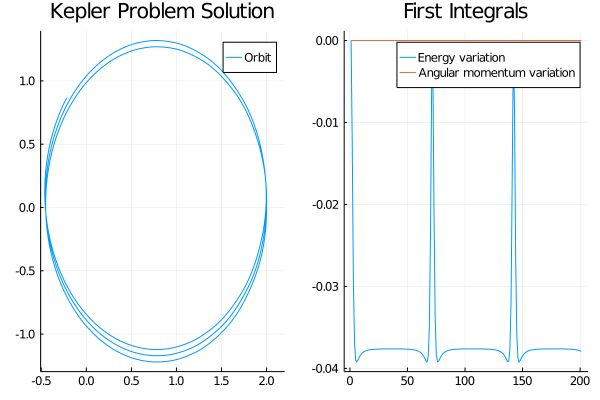

In [254]:
analysis_plot(sol, H, AngM)

sol2.u |> length = 80


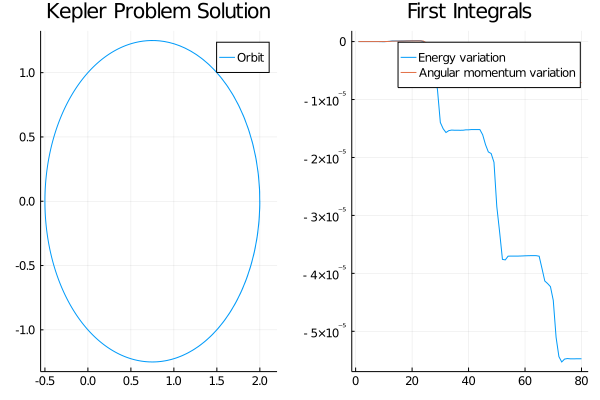

In [257]:
sol2 = solve(prob, DPRKN6())  # dt is not necessary, because unlike symplectic
                              # integrators DPRKN6 is adaptive
@show sol2.u |> length
analysis_plot(sol2, H, AngM)

In [218]:
sol

retcode: Success
Interpolation: 3rd order Hermite
t: 201-element Array{Float64,1}:
  0.0
  0.1
  0.2
  0.30000000000000004
  0.4
  0.5
  0.6
  0.7
  0.7999999999999999
  0.8999999999999999
  0.9999999999999999
  1.0999999999999999
  1.2
  ⋮
 18.9
 19.0
 19.1
 19.200000000000003
 19.300000000000004
 19.400000000000006
 19.500000000000007
 19.60000000000001
 19.70000000000001
 19.80000000000001
 19.900000000000013
 20.0
u: 201-element Array{RecursiveArrayTools.ArrayPartition{Float64,Tuple{Array{Float64,1},Array{Float64,1}}},1}:
 ([0.0, 2.0], [0.4, 0.0])
 ([-0.5830949354540153, 1.8556656829703986], [0.36982713146498514, 0.19503596514776078])
 ([-0.9788105843777309, 1.5274462532150215], [0.2898783086361091, 0.36495974735762704])
 ([-1.1754776266590499, 1.1751394486895788], [0.18078065407309696, 0.4998457720618295])
 ([-1.2440239387295455, 0.8720450804540066], [0.059029253347515215, 0.6016956802132388])
 ([-1.2441259417439434, 0.6289994697149086], [-0.06577256855272459, 0.6762747102291484])

## Solving Hamiltonian PDEs with Symplectic Integrators

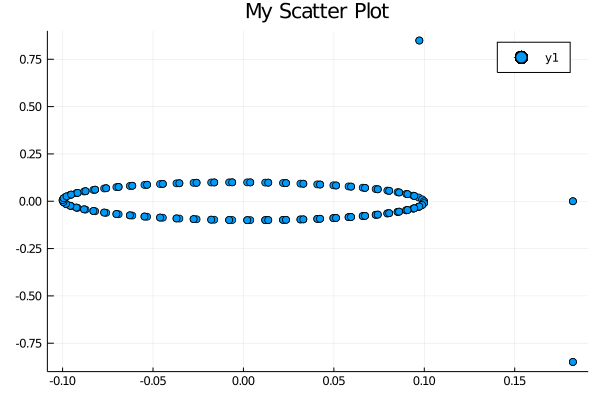

In [181]:
# Solving the Wave Equation

# Defining constants
h = 0.1
L = 2*pi

# Boundary conditions
u0, uL = 0, 0

# Initial condition
f(x) = sin(x)
steps = [0+h:h:L-h;]
u_init = f.(steps)

q_init = u_init
p_init = steps*0

# Define 2nd derv. matrix
n = length(steps)
lol = zeros(n, n)
lol[diagind(lol)] .= 2
lol[diagind(lol, 1)] .= -1
lol[diagind(lol, -1)] .= -1
lol = (1/h^2) .* lol

Uv_1, tv_1 = eulerA_method(r -> -lol * r, vcat(q_init, p_init), 0.1, 20)

plot(Uv_1[1,:], Uv_1[1+n,:], seriestype = :scatter, title = "My Scatter Plot")

In [113]:
vcat(q_init, p_init)

122-element Array{Float64,1}:
 0.09983341664682815
 0.19866933079506122
 0.2955202066613396
 0.3894183423086505
 0.479425538604203
 0.5646424733950354
 0.6442176872376911
 0.7173560908995228
 0.7833269096274834
 0.8414709848078965
 0.8912073600614354
 0.9320390859672264
 0.9635581854171931
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

**References**

    [1] Overview of Sympletic Integrators: https://aapt.scitation.org/doi/10.1119/1.2034523 
    [2] Hamiltonian System Derivation: https://www.youtube.com/watch?v=FGQddvjP19w